# Google Colab 连接

In [ ]:
%%javascript
function ClickConnect(){
  console.log("Working");
  document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Wuhan_taxi_data'

Mounted at /content/gdrive


# 导入所需要的库

In [ ]:
! pip3 install fastprogress
from fastprogress import master_bar, progress_bar
 
import numpy as np
from numpy import log

import pandas as pd
from pandas.api.types import CategoricalDtype, is_numeric_dtype

from datetime import datetime

!pip3 install geopandas
import geopandas as gpd

!pip install rtree

!pip install geoplot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 45.7 MB/s 
     |████████████████████████████████| 6.3 MB 39.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 37.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 36.3 MB/s 
  Installing build 

# 1.轨迹数据预处理

该部分通过各种可视化和预处理的方法，初探出租车轨迹数据，最终匹配到路网上。

## 1.1 轨迹数据关键字段提取与排序优化

从原始文件中读取并对其数据

In [ ]:
import glob
import pandas as pd

def inter(a,b):  # 判断是否相交
    return list(set(a)&set(b))

def extract_track_files(path):  # 抽取轨迹实习材料的原始轨迹文件夹中的txt文件
    files = [filename for filename in glob.glob(path + '*.txt')]#遍历一个目录下面所有的存放轨迹的txt文件
    return files

def get_track_points(filename):  # 读取轨迹文件中的轨迹点
    lines = []  # 存放单个轨迹文件中的所有轨迹点，由于每行中的字段可能并不完整，无法直接对齐生成Data Frame
    with open(filename, 'rb') as f: # 这里先用二进制读入，下面再解码，比文本读入速度更快
        for fLine in f:
            fLine = fLine.decode(encoding='gbk').strip()# 每行最后有一个换行符，需要去掉
            line = [item for item in fLine.split(',')]# 按照逗号分割字段
            lines.append(line)
    f.close()
    return lines

def align_points(lines):  # 提取分析需要的字段，对齐轨迹点，并生成Data Frame
    # 原始轨迹数据中包含的异常内容大致如下所示，若发现新的异常值，可进行补充
    anomalies = ['超速报警', '补传', '定位故障', 'LED故障', '摄像头故障', '未定位', '溜车报警', '计价器故障', '紧急报警', '超速', 'ACC关']
    df = pd.DataFrame()  # 新建一个数据框
    ls=[]
    points = [line[:7] for line in lines if not inter(line,anomalies)]# 清理、对齐轨迹点
    df = df.append(points)
    ls.append(points)
    df.columns = ['出租车ID', '定位时间', '经度', '纬度', '方向', '速度', '空车/重车']  # 本次实习需要用到字段说明表里的前7个字段
    return df,ls

In [ ]:
# 完成轨迹点的文件读取
# 需要对应将dir换成测试文件所在目录
dir='/content/gdrive/MyDrive/SA/data/raw/'
files=extract_track_files(dir)
print(files)
# 数据量较大，首先以其中一个文件为例
track_points = get_track_points(files[0])
df,ls=align_points(track_points)

#完成轨迹点所需字段的切片，并通过数据表输出展示：
print(df.head(10))

下面通过对比使用Pandas DataFrame的排序函数按照多列进行排序和使用列表结构对数据进行排序的各自耗费的时间，来验证DataFrame封装的排序函数实现排序的效率优势。但是原生数据结构排序灵活性更强，可根据个人需要自定义多种排序方案。

In [ ]:
# 使用Pandas DataFrame的排序函数，按照多列进行排序。
time_start1=time.time()
df.sort_values(by=['出租车ID','定位时间'], inplace=True)
# 重新生成索引
df=df.reset_index(drop=True)
time_end1=time.time()
print('使用Pandas DataFrame的排序函数time cost',time_end1-time_start1,'s')

# 使用列表结构对数据进行排序，对排序进行优化

import operator
list_raw=[]
for i in range(len(ls[0])):
    list_raw.append(ls[0][i])     
time_start=time.time()
list_sorted=sorted(list_raw, key=operator.itemgetter(0, 1))
time_end=time.time()
print('使用列表结构进行排序time cost',time_end-time_start,'s')

In [ ]:
def sort_points(df):
    # 按条件排序
    df.sort_values(by=['出租车ID','定位时间'], inplace=True)
    # 重新生成索引
    df=df.reset_index(drop=True)

    # 在上下车时刻，数据里会有两条仅 空车/重车 字段不同的记录，形如
    # 100 2018-11-05 00:00:00 -- -- -- -- 空车
    # 100 2018-11-05 00:00:00 -- -- -- -- 重车
    # 经过上述排序后可能造成该字段的顺序出错，需要整理
    old_index=None
    old_row=None
    for index, row in df.iterrows():
        if old_index == None:
            old_index=index
            old_row=row
            continue
        if (row['出租车ID']==old_row['出租车ID'] and
            row['定位时间']==old_row['定位时间'] and 
            row['经度']==old_row['经度'] and 
            row['纬度']==old_row['纬度'] and 
            row['方向']==old_row['方向'] and 
            row['速度']==old_row['速度'] and 
            row['空车/重车']!=old_row['空车/重车']):
            #判断是否出现误排
            #看更前一行的状态
            older_row=df.iloc[old_index-1]
            if older_row['出租车ID']==row['出租车ID'] and older_row['空车/重车']==row['空车/重车']:
                # 交换，这并不会影响iterrows迭代器
                temp=df.iloc[index]
                df.iloc[index]=df.iloc[old_index]
                df.iloc[old_index]=temp
        old_index=index
        old_row=row

        return df
df=sort_points(df)
df.to_csv(root_path+'/data/processed.txt',index=False)


## 1.2 上下车点提取与轨迹分段

In [ ]:
import pandas as pd

# 读取
df=pd.read_csv(root_path+'/data/processed.txt')
# 对某辆出租车轨迹进行分段，提取上下车点
def get_sub_trajectory(df1):
  '''
  loads:重车点子轨迹集合
  no_loads:空车点子轨迹集合
  pick_up:上车点集合
  drop_off：下车点集合
  '''
  loads=[]
  no_loads=[]
  on_board=[]
  pick_up=[]
  drop_off=[]
  # 辅助记录
  idx1=-1 #记录每一段轨迹的开始
  idx2=-1 #记录每一段轨迹的结束
  old_status=''
  for index, row in df1.iterrows():
      status=row['空车/重车']
      # 初始化
      if index==0:
          idx1=index
          old_status=status
      # 判断状态是否转变
      # 记录状态改变的行索引
      if status!=old_status:
          sub_df=df1[idx1:idx2+1]
          if old_status=='重车':
              loads.append(sub_df)
              drop_off.append((row['经度'],row['纬度']))
          else:
              no_loads.append(sub_df)
              pick_up.append((row['经度'],row['纬度']))
          idx1=index
          idx2=index
          old_status=status
      else:
          idx2=index
  sub_df=df1[idx1:idx2+1]
  if old_status=='重车':
      loads.append(sub_df)
  else:
      no_loads.append(sub_df)
  return loads,no_loads,pick_up,drop_off

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 选取某一辆出租车作为示例进行处理
df1=df[df['出租车ID']==1015]
# 构造GeoDataFrame对象
gdf1 = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1['经度'], df1['纬度']),crs=4326)


1. 根据轨迹点的空/重车状态直接进行可视化绘制

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)


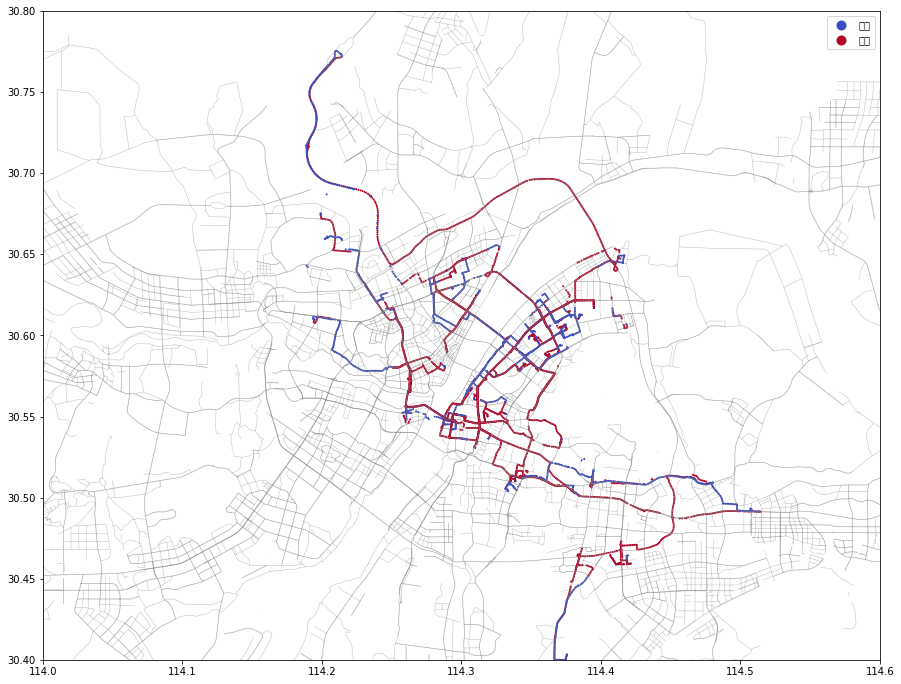

In [ ]:
# 使matplotlib支持中文字体
plt.rcParams['font.family']=['SimHei']
# 绘图，分别指定渲染字段、颜色表、显示图例、点大小、图片大小
ax=gdf1.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(15,15))
# 指定范围
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road = gpd.GeoDataFrame.from_file(root_path+'/data/osmroad/osmWHmainRoad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

2. 考虑对轨迹点采用先分段、再渲染的可视化方式，对分段轨迹可视化进行优化。与上图直接按照重/空车的状态进行可视化绘制的结果图相比，先分段、再渲染的绘制方法不仅可以通过可视化结果区分载客状态，还可以更为细化得区分到每个载客状态的每个分段路径。

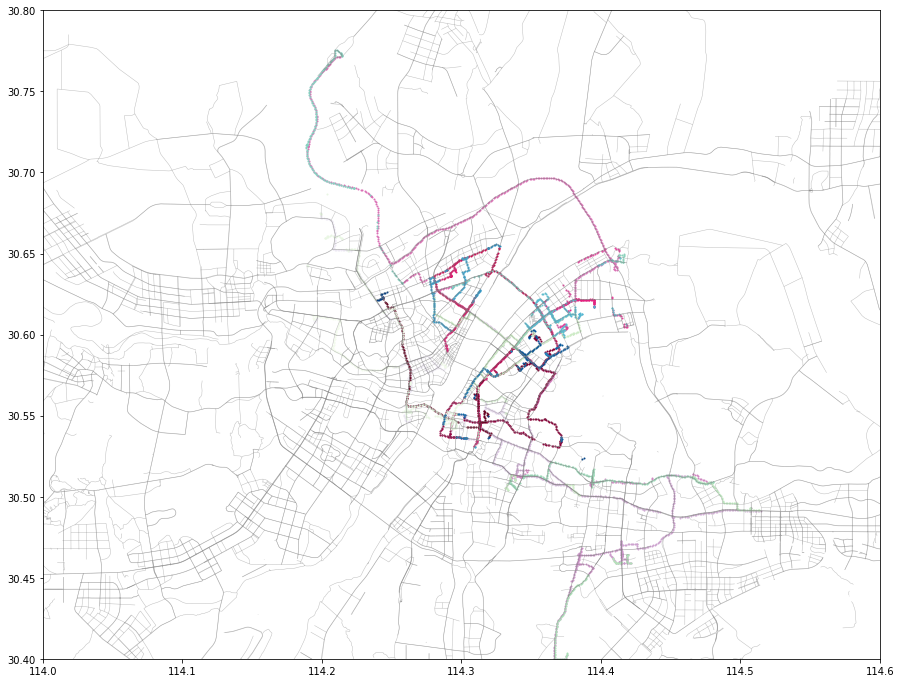

In [ ]:
loads,no_loads,pick_up,drop_off=get_sub_trajectory(df1)
gdfloads=[]
gdfnoloads=[]

for i in range(len(loads)):
    #print(loads[i])
    gdfload=gpd.GeoDataFrame(
        loads[i], geometry=gpd.points_from_xy(loads[i]['经度'], loads[i]['纬度']),crs=4326)
    gdfloads.append(gdfload)
    
for i in range(len(no_loads)):
    #print(loads[i])
    gdfnoload=gpd.GeoDataFrame(
        no_loads[i], geometry=gpd.points_from_xy(no_loads[i]['经度'], no_loads[i]['纬度']),crs=4326)
    gdfnoloads.append(gdfnoload)
import numpy
# 使matplotlib支持中文字体
plt.rcParams['font.family']=['SimHei']

# 叠加武汉市路网
road = gpd.GeoDataFrame.from_file(root_path+'/data/osmroad/osmWHmainRoad.shp')

ax=road.plot(linewidth=0.5,alpha=0.5,color='grey',figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])

# 为重车状态与空车状态分别设置不同的颜色映射
cmap1 = plt.get_cmap('PuRd')
cmap2 = plt.get_cmap('GnBu')
# 重车状态
for i in range(len(gdfloads)):
    ax1=gdfloads[i].plot(ax=ax,color = cmap1(float(i+1) / float(len(gdfloads))),legend=True,markersize=1,figsize=(15,15))
    ax=ax1
# 空车状态
for i in range(len(gdfnoloads)):
    ax1=gdfnoloads[i].plot(ax=ax,color = cmap2(float(i+1) / float(len(gdfnoloads))),legend=True,markersize=1,figsize=(15,15))
    ax=ax1

## 1.3 轨迹数据的滤波、补全等预处理


考虑到apply方法拥有较小的时间复杂度和算法复杂度，这里采用用GeoDataFrame的apply方法替换for循环遍历，减少时间成本以提高效率。
二者的运算逻辑差别在于，for循环会对数据框的中的每一个值进行遍历，而apply方法虽然也是作用于数据框的每个值,但是每次接受的参数不是各个值本身,而是数据框里的一列或一行,并返回一个新的列或行。

In [ ]:
import time,datetime
import math

from pyproj import Transformer
transformer1 = Transformer.from_crs(4326, 32649)
transformer2 = Transformer.from_crs(32649, 4326)

def interpolation(trac):
    trac_inter=pd.DataFrame()
    # 对太少的轨迹进行剔除
    if len(trac)<10:
        return trac_inter
    time1=datetime.datetime.strptime(trac.loc[0,'定位时间'], "%Y-%m-%d %H:%M:%S")
    for index, row in trac.iterrows():
        trac_inter=trac_inter.append(row,ignore_index=True)
        t1=datetime.datetime.strptime(row['定位时间'], "%Y-%m-%d %H:%M:%S")
        time_delta=(t1-time1).seconds
        # 180s内无数据，则干脆抛弃这条轨迹
        if time_delta>180:
            return pd.DataFrame()
        # 30s内无数据，则插值
        if time_delta>30:
            # 以15s间隔插值
            new_points=pd.DataFrame()
            n=int(time_delta/15)
            for i in range(n):
                time1=(time1+datetime.timedelta(seconds=15))
                row['定位时间']=time1.strftime("%Y-%m-%d %H:%M:%S")
                utm_x, utm_y = transformer1.transform(row['纬度'],row['经度'])
                delta_d=float(row['速度'])*1000/60/4
                delta_y=-math.sin(float(row['方向'])*2*math.pi/360)
                delta_x=math.cos(float(row['方向'])*2*math.pi/360)
                lat,lng=transformer2.transform(utm_x+delta_x,utm_y+delta_y)
                row['纬度']=lat
                row['经度']=lng
                trac_inter=trac_inter.append(row,ignore_index=True)
        time1=t1
    return trac_inter

def mean_filter(trac,n):
    # 窗口大小应该是奇数
    n=int(n/2)*2+1
    # 判断窗口大小
    if len(trac)<n:
        return pd.DataFrame()
    trac_filter=trac
    for i in range(int(n/2),len(trac)-int(n/2)):
        # 对于中间的点，进行均值滤波
        sub_df=trac[i-int(n/2):i+int(n/2)+1]
        lat=0.0
        lng=0.0
        for index, row in sub_df.iterrows():
            lat+=float(row['纬度'])
            lng+=float(row['经度'])
        lat/=n
        lng/=n
        # 将结果重新赋值
        trac_filter.loc[i,'纬度']=lat
        trac_filter.loc[i,'经度']=lng
    return trac_filter

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36710 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)


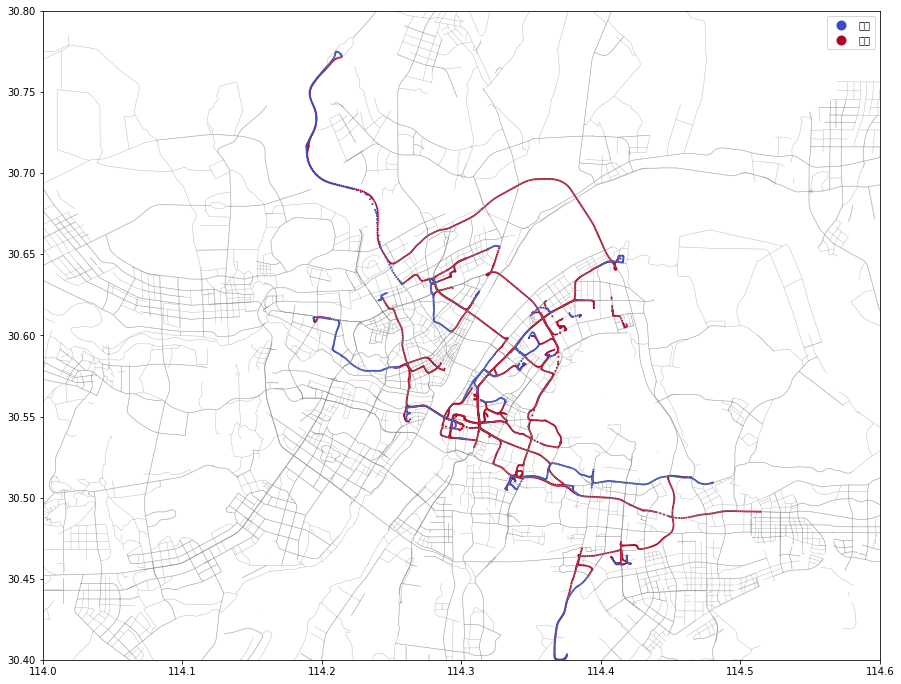

In [ ]:
# 对于某一条出租车轨迹
df1=df[df['出租车ID']==1015]
df1=df1.reset_index(drop=True)
# 首先提取所有轨迹段
loads,no_loads,pick_up,drop_off=get_sub_trajectory(df1)

new_loads=pd.DataFrame()
new_no_loads=pd.DataFrame()

# 对于所有的轨迹片段，分别进行内插、滤波
n=5
for trac in loads:
    trac=trac.reset_index(drop=True)
    trac=interpolation(trac)
    trac_filter=mean_filter(trac,n)
    new_loads=new_loads.append(trac_filter,ignore_index=True)
for trac in no_loads:
    trac=trac.reset_index(drop=True)
    trac=interpolation(trac)
    trac_filter=mean_filter(trac,n)
    new_no_loads=new_no_loads.append(trac_filter,ignore_index=True)

# 汇总滤波之后的轨迹
new_df=new_loads.append(new_no_loads)
new_df.head(5)

# 可视化查看
gdf = gpd.GeoDataFrame(
    new_df, geometry=gpd.points_from_xy(new_df['经度'], new_df['纬度']))
ax=gdf.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road = gpd.GeoDataFrame.from_file(root_path+'/data/osmroad/osmWHmainRoad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

## 1.4 地图匹配

对于滤波预处理之后的轨迹点，下面需要进行路网的匹配。最常见、最简单的路网匹配算法是基于距离的，将轨迹点匹配到距离最近的道路上。我们采取以下的路网匹配策略：

1.   对每个轨迹片段，计算缓冲区；
2.   将缓冲区与路网计算交集；
3.   对轨迹片段上的每个点，与上述交集的最近点即为匹配点


In [ ]:
from shapely.geometry import LineString,Point
from shapely.ops import nearest_points
import pyproj

# 投影相关
wgs84=pyproj.CRS.from_epsg(4326)
utm49N=pyproj.CRS.from_epsg(32649)
myTrans=pyproj.Transformer.from_crs(utm49N,wgs84)

def mapping(trac,radius,road):
    mapped=trac
    # 点转线
    if len(trac)==0:
        return pd.DataFrame()
    xylist=[xy for xy in zip(trac['经度'],trac['纬度'])]
    line=LineString(xylist)
    #print(line)
    gdf = gpd.GeoDataFrame(geometry = [line],crs=4326)
    # WGS84 转 UTM zone 49N:
    gdf = gdf.to_crs(32649)
    # 线缓冲区
    gs_buffer=gdf.buffer(radius)
    gs_buffer=gs_buffer.to_crs(4326)
    gdf_buffer=gpd.GeoDataFrame(geometry=gs_buffer)
    # 与路网求交
    subroad = gpd.overlay(road,gdf_buffer, how = 'intersection').to_crs(32649)
    # 遍历轨迹点，计算距离
    if subroad.geometry.unary_union.is_empty:
        return mapped
    for index, row in trac.iterrows():
        pt = gpd.GeoSeries([Point(row['经度'],row['纬度'])],crs=4326).to_crs(32649)
        # 使用shapely的nearest_points方法计算点到线上的最近点，该点即为匹配点
        npts= nearest_points(pt[0],subroad.geometry.unary_union)
        npt=npts[1]
        # 注意投影变换
        npt=myTrans.transform(npt.x,npt.y)
        mapped.loc[index,'经度']=npt[1]
        mapped.loc[index,'纬度']=npt[0]
    print(subroad.geometry.unary_union)
    return mapped

In [ ]:
# 对于某一条出租车轨迹
df1=df[df['出租车ID']==1015]
df1=df1.reset_index(drop=True)
# 首先提取所有轨迹段
loads,no_loads,pick_up,drop_off=get_sub_trajectory(df1)

new_df=pd.DataFrame()

# 对于所有的轨迹片段，先内插，分别进行匹配
dis=10
for trac in no_loads:
    trac=trac.reset_index(drop=True)
    trac=interpolation(trac)
    trac_mapped=mapping(trac,dis,road)
    new_df=new_df.append(trac_mapped,ignore_index=True)
for trac in loads:
    trac=trac.reset_index(drop=True)
    trac=interpolation(trac)
    trac_mapped=mapping(trac,dis,road)
    new_df=new_df.append(trac_mapped,ignore_index=True)

# 可视化查看
gdf = gpd.GeoDataFrame(
    new_df, geometry=gpd.points_from_xy(new_df['经度'], new_df['纬度']))
ax=gdf.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road = gpd.GeoDataFrame.from_file(root_path+'/data/osmroad/osmWHmainRoad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

ImportError: ignored

# 2.轨迹聚类 

## 2.1 上下车点聚类

首先对第一天数据的前十万条做上下车点的可视化，直观上了解其空间分布。

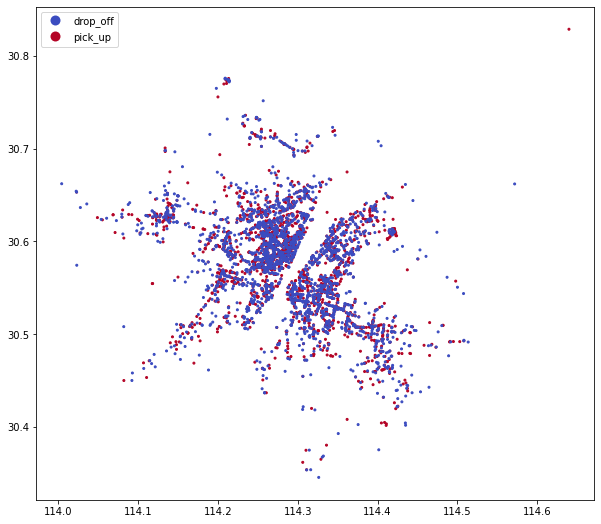

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

df=pd.read_csv('/content/gdrive/MyDrive/Wuhan_taxi_data/data/processed.txt')
#如果不按照用户
'''
taxi_ODs = get_sub_trajectory(taxi_df)[2]
print(len(taxi_ODs))
'''
df1=df.head(360000)
x,x,pick_up,drop_off=get_sub_trajectory(df1)
# 构造dataframe便于操作
pick_df=pd.DataFrame(pick_up)
pick_df.columns = ['经度','纬度']
pick_df['类型'] = 'pick_up'
drop_df=pd.DataFrame(drop_off)
drop_df.columns = ['经度','纬度']
drop_df['类型'] = 'drop_off'
# index重设
points_df=pick_df.append(drop_df).reset_index(drop=True)
gdf = gpd.GeoDataFrame(
    points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']),crs=4326)
ax=gdf.plot(column='类型',cmap='coolwarm',legend=True,markersize=4,figsize=(10,10))
# ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/pick_drop.png", dpi=200, bbox='tight')

1. 使用轮廓系数来作为评价聚类方法的指标

In [ ]:
# 轮廓系数指标的定义
import sklearn.metrics as sm
def get_silhouette_score(model):
    pred_y = model.predict(data)
    silhouette_score = sm.silhouette_score(data, pred_y, sample_size=len(data), metric='euclidean')
    print(silhouette_score)
    return silhouette_score

# label为-1噪声点会拉低整体指标
def get_silhouette_score_db(model):
    pred_y = db.fit_predict(data)
    silhouette_score = sm.silhouette_score(data, pred_y, sample_size=len(data), metric='euclidean')
    print(silhouette_score)

def get_cluster_num(model):
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print("number of estimated clusters : %d" % n_clusters_)
    return n_clusters_

2. 使用K-means算法进行聚类，并调整不同的聚类参数，通过衡量其轮廓系数，挑选出聚类效果最好的聚类参数，聚类后的图片以及聚类参数显示如下，可以看出，当聚类系数n_cluster=7时，理论上讲有着较好的聚类效果。

n_cluster=30
0.4050543569334714
n_cluster=20
0.3958813241843511
n_cluster=10
0.39957494842722485
n_cluster=7
0.4454179110937144
n_cluster=6
0.42467300237918043
n_cluster=5
0.39791033648762864


0.39791033648762864

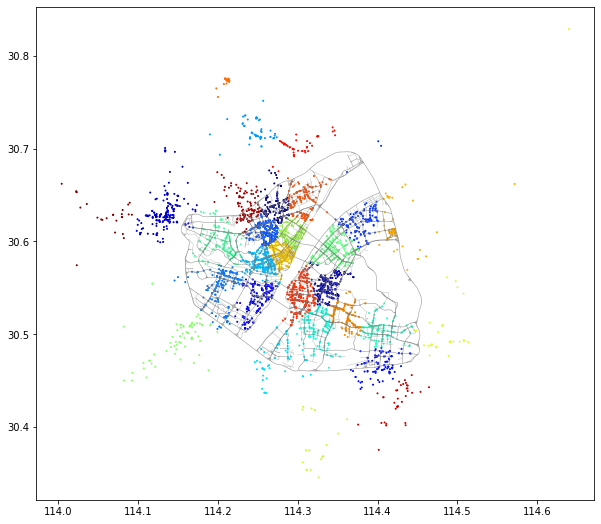

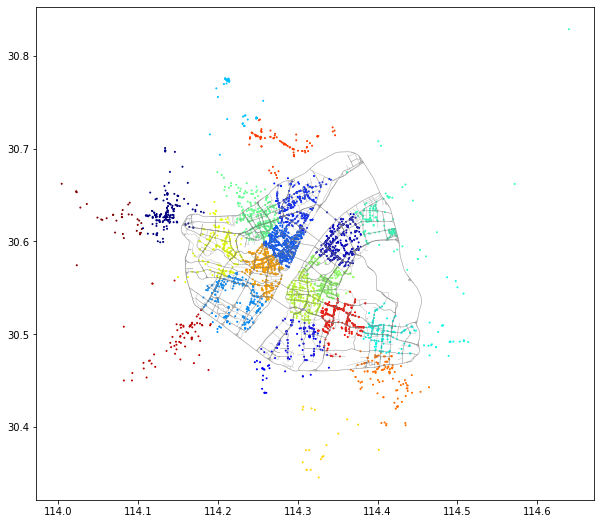

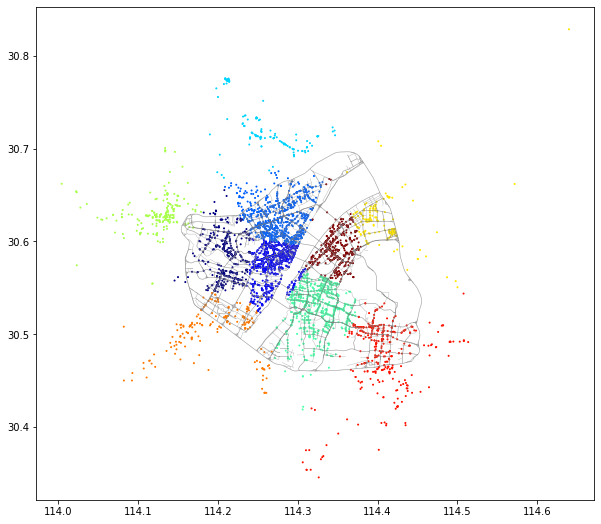

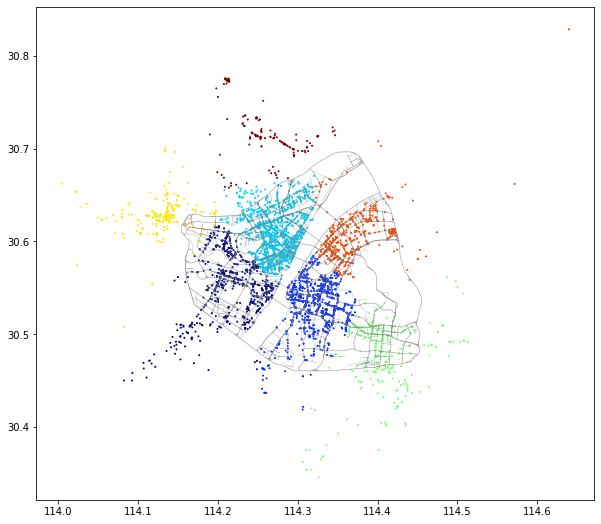

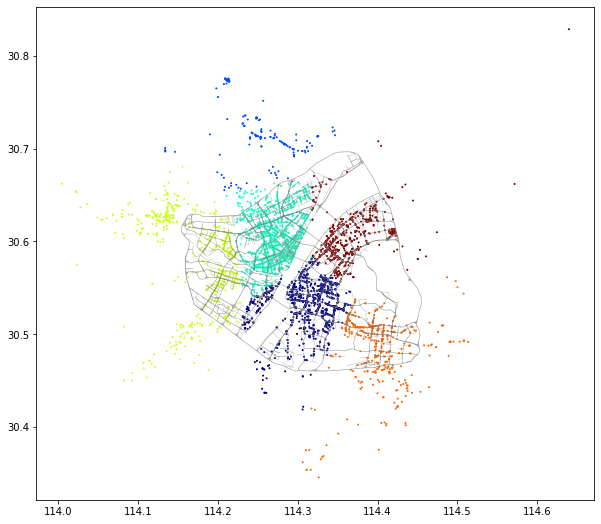

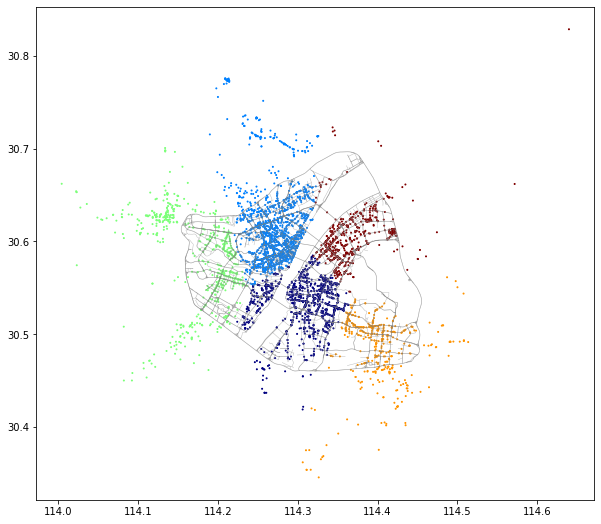

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
data=np.array(points_df.loc[:, ['经度', '纬度']])

# 对K-means算法调用不同的聚类参数，并使用轮廓系数对其进行打分
print("n_cluster=30")
kmeans_30 = KMeans(n_clusters=30).fit(data)
points_df['K']=kmeans_30.labels_
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='K',cmap='jet',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/30cluster.png", dpi=200)
get_silhouette_score(kmeans_30)

print("n_cluster=20")
kmeans_20 = KMeans(n_clusters=20).fit(data)
points_df['K']=kmeans_20.labels_
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='K',cmap='jet',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/20cluster.png", dpi=200)
get_silhouette_score(kmeans_20)

print("n_cluster=10")
kmeans_10 = KMeans(n_clusters=10).fit(data)
points_df['K']=kmeans_10.labels_
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='K',cmap='jet',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/10cluster.png", dpi=200)
get_silhouette_score(kmeans_10)

print("n_cluster=7")
kmeans_7 = KMeans(n_clusters=7).fit(data)
points_df['K']=kmeans_7.labels_
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='K',cmap='jet',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/7cluster.png", dpi=200)
get_silhouette_score(kmeans_7)

print("n_cluster=6")
kmeans_6 = KMeans(n_clusters=6).fit(data)
points_df['K']=kmeans_6.labels_
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='K',cmap='jet',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/6cluster.png", dpi=200)
get_silhouette_score(kmeans_6)

print("n_cluster=5")
kmeans_5 = KMeans(n_clusters=5).fit(data)
points_df['K']=kmeans_5.labels_
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='K',cmap='jet',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/5cluster.png", dpi=200)
get_silhouette_score(kmeans_5)



0.41594769655436925
0.37524037114776915
0.38291428550277967
0.397712494302853
0.4145845137341567
0.4454816327334028
0.3946189375533967
0.40665927392276663
0.3981326584462162
0.4057242591233152
0.40575603720490283
0.41230177938953033
0.41269210464894807
0.40881975143079285
0.40489071084141576
0.4011553987271045
0.3997478020137764
0.4073836461850909
0.41083875284109483
0.41361000463213266
0.40816552312520865
0.41396384117703644
0.40093991568859183
0.3930557540128518
0.39823448230358965
0.39404562561845563
0.40714663877607093
0.40045753749993845
0.39555229952579435


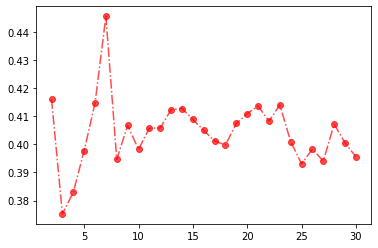

In [ ]:
# 轮廓系数法
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
data=np.array(points_df.loc[:, ['经度', '纬度']])

silhouette_score = []
for n in range(29):
  n_clusters = n + 2
  kmeans_n = KMeans(n_clusters=n_clusters).fit(data)
  silhouette_score.append(get_silhouette_score(kmeans_n))

plt.plot(np.arange(2,31), silhouette_score, color='r', linestyle='-.', marker='o', alpha=0.7)
plt.savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/silhouette_score.png", dpi=200)

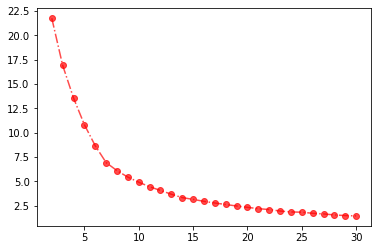

In [ ]:
# 手肘法
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
data=np.array(points_df.loc[:, ['经度', '纬度']])

sse_score = []
for n in range(29):
  n_clusters = n + 2
  kmeans_n = KMeans(n_clusters=n_clusters).fit(data)
  sse_score.append(kmeans_n.inertia_)

plt.plot(np.arange(2,31), sse_score, color='r', linestyle='-.', marker='o', alpha=0.7)
plt.savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/sse_score.png", dpi=200, bbox='tight')

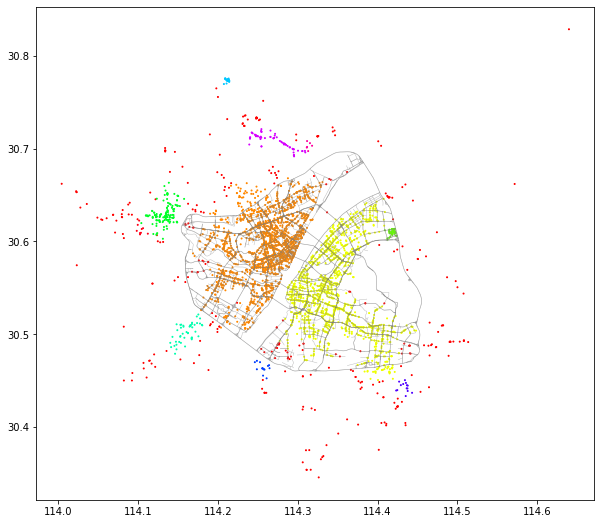

In [ ]:
from sklearn.cluster import DBSCAN

db=DBSCAN(eps=0.01,min_samples=10).fit(data)
#赋值
points_df['DB']=db.labels_
#核心
core=points_df[points_df['DB']>-1]
#边界
border=points_df[points_df['DB']==-1]
# 分别可视化
cluster_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df['经度'], points_df['纬度']))
track_ax = cluster_gdf.plot(column='DB',cmap='hsv',markersize=1,figsize=(10,10))
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax = wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')
ax.get_figure().savefig("/content/gdrive/MyDrive/Wuhan_taxi_data/img/DBSCAN.png", dpi=200, bbox='tight')

## 2.2 上下车点热区分析

使用所有的出租车轨迹，进行上下车点的热区分析，这里我们使用第一天的数据，对全天上下车点做可视化，观察其空间分布。

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/Wuhan_taxi_data/data/processed.txt')
pick=pd.DataFrame()
drop=pd.DataFrame()
for tid in set(df['出租车ID']):
    df1=df[df['出租车ID']==tid].reset_index(drop=True)
    x,x,pick_up,drop_off=get_sub_trajectory(df1)
    if len(pick_up)>0:
        pick_df=pd.DataFrame(pick_up)
        pick_df.columns = ['经度','纬度']
        pick_df['类型'] = '上车点'
        pick_df['出租车ID'] = tid
        pick=pick.append(pick_df)
    if len(drop_off)>0:
        drop_df=pd.DataFrame(drop_off)
        drop_df.columns = ['经度','纬度']
        drop_df['类型'] = '下车点'
        drop_df['出租车ID'] = tid
        drop=drop.append(drop_df)
pick=pick.reset_index(drop=True)
drop=drop.reset_index(drop=True)

这里使用对核密度函数可视化做一个函数定义，用来更加方便地绘制全天或某一条轨迹的上下车点核密度，并叠加DBSCAN聚类后的图层进行分析。

In [ ]:
def kernelDensityPlot(pick,drop,id):
    if(id!='all'):
        pick=pick[pick['出租车ID']==id]
        drop=drop[drop['出租车ID']==id]
    gdf_pick = gpd.GeoDataFrame(
        pick, geometry=gpd.points_from_xy(pick['经度'], pick['纬度']),crs=4326)
    gdf_drop = gpd.GeoDataFrame(
        drop, geometry=gpd.points_from_xy(drop['经度'], drop['纬度']),crs=4326)
    plt.rcParams['font.family']=['SimHei']

    ax1=gdf_pick.plot(column='类型',color='red',legend=True,markersize=2,figsize=(10,10))
    ax1.set_ylim([30.4,30.8])
    ax1.set_xlim([114.0,114.6])
    ax2=gdf_drop.plot(column='类型',color='blue',legend=True,markersize=2,figsize=(10,10))
    ax2.set_ylim([30.4,30.8])
    ax2.set_xlim([114.0,114.6])

    wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
    wuhan_road.plot(ax=ax1,linewidth = 0.5, alpha = 0.5, color = 'black')
    wuhan_road.plot(ax=ax2,linewidth = 0.5, alpha = 0.5, color = 'black')   
    
    import geoplot as gplt
    ax1=gplt.kdeplot(df=gdf_pick,cmap='Reds',shade=True)
    ax1.set_ylim([30.4,30.8])
    ax1.set_xlim([114.0,114.6])

    ax2=gplt.kdeplot(df=gdf_drop,cmap='Blues',shade=True)
    ax2.set_ylim([30.4,30.8])
    ax2.set_xlim([114.0,114.6])

    # 路网参考
    wuhan_road.plot(ax=ax1,linewidth = 0.5, alpha = 0.5, color = 'black')
    ##叠加MeanShift的图层
    track_ax = cluster_gdf.plot(ax=ax1,column='K',cmap='jet',legend=True,markersize=1,figsize=(10,10))
    wuhan_road.plot(ax=ax2,linewidth = 0.5, alpha = 0.5, color = 'black')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


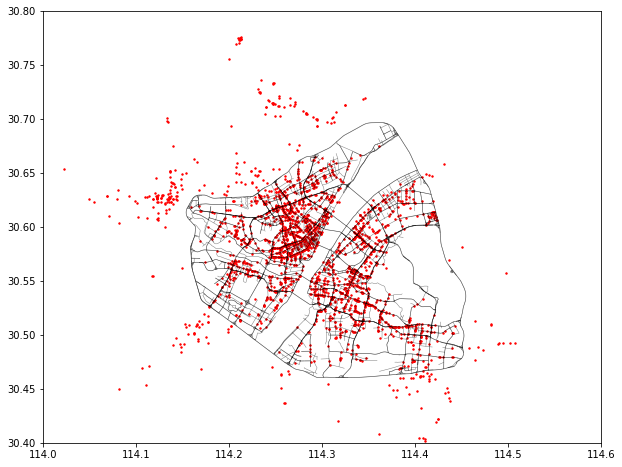

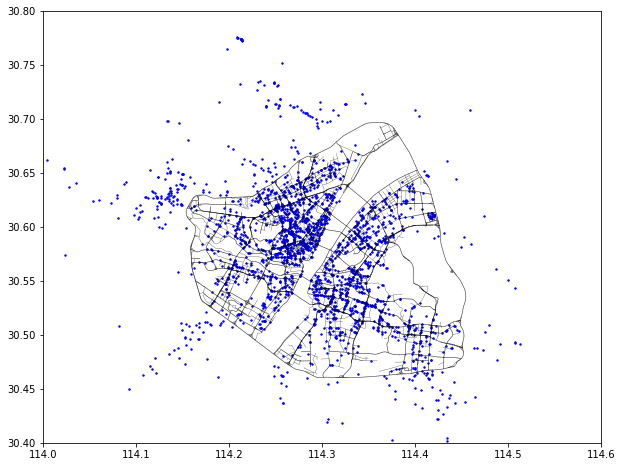

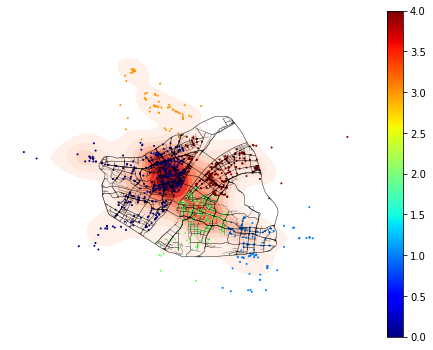

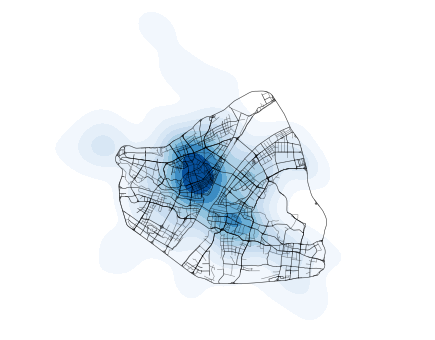

In [ ]:
kernelDensityPlot(pick,drop,'all')

geoplot的kdeplot还有众多调整参数，可以尝试进行参数调整，得到更好的效果

当然，由于上面使用全天的数据，使得上下车点的空间分布模式并不显著，核密度图也比较简单，这里建议选取部分轨迹（按照id或按照时间）进行尝试，下面有相关提取轨迹代码，可供参考

请尝试叠加核密度和DBSCAN聚类结果进行分析

In [ ]:
def kernel(t):
  """核函数。"""
  return (3. / math.pi) * (1 - t * t) ** 2

In [ ]:
def avgPt(pts):
  """平均中心。"""
  lat, lon = 0., 0.
  for pt in pts:
    lat += pt.lat
    lon += pt.lon
  return lat / len(pts), lon / len(pts)

In [ ]:
def SD(pts, avgPt):
  """标准距离。"""
  SDx, SDy = 0., 0.
  for pt in pts:
    SDx += (pt.lon - avgPt.lon) ** 2
    SDy += (pt.lat - avgPt.lat) ** 2
  return SDx / len(pts), SDy / len(pts)

In [ ]:
def dist(pt1, pt2):
  return math.sqrt((pt1.lat - pt2.lat) ** 2 + (pt1.lon - pt2.lon) ** 2)

def Dm(pts, avgPt):
  """到平均中心距离的中值。"""
  distance = []
  for pt in pts:
    distance.add(dist(pt, avgPt))
  distance = distance.sort()
  return distance[math.floor(len(distance) / 2)]

In [ ]:
def h(pts, avgPt):
  """
  pts: 所有PoI点
  avgPt: 平均中心
  
  return: 带宽
  """
  SD_ = SD(pts, avgPt)
  Dm_ = Dm(pts, avgPt)
  if SD_ > math.sqrt(1 / math.log(2)) * Dm:
    return 0.9 * math.sqrt(1 / math.log(2)) * Dm_ * math.pow(len(pts), 2)
  else:
    return 0.9 * SD_ * math.pow(len(pts), 2)

## 2.3 载客轨迹的聚类

主要考虑使用DTW算法度量两条轨迹的距离，自动扭曲两个序列，并在时间轴上进行局部的缩放对齐，以使其形态尽可能一致，从而得到最大可能的相似性。DTW将两条轨迹的点进行多对多的映射，从而较为高效地解决了数据不齐的问题。

本次实习聚类的轨迹为载客轨迹，因此需要在第一次实习的基础上提取出载客的轨迹并为每条轨迹分配一个唯一编号，处理方法是为loads轨迹列表中每个轨迹的DataFrame添加一列TID字段，同一条轨迹的TID是一致的。

In [ ]:
loads_track = get_sub_trajectory(pd.read_csv('/content/gdrive/MyDrive/Wuhan_taxi_data/data/processed.txt'))[0]  # 载客轨迹是返回参数的第一个
reserved_tracks = []
track_id = 1
for i in range(0, len(loads_track)):
    if len(loads_track[i]) > 20:
        loads_track[i]['TID'] = track_id
        track_id += 1
        reserved_tracks.append(loads_track[i])
print(loads_track[0])
track_df_1110 = pd.concat(reserved_tracks)  # 所有DataFrame拼接为一个
track_df_1110.to_csv('/content/gdrive/MyDrive/Wuhan_taxi_data/data/Load_Tracks_1110.txt',index=False, encoding="utf_8_sig")  # 保存轨迹记录，方便后续调用

    出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车
0    1015  2018-11-05 00:00:22  114.206137  30.610543  278  71    重车
1    1015  2018-11-05 00:00:28  114.204898  30.610702  276  72    重车
2    1015  2018-11-05 00:00:34  114.203683  30.610835  276  70    重车
3    1015  2018-11-05 00:00:34  114.203683  30.610835  276  70    重车
4    1015  2018-11-05 00:00:40  114.202515  30.610963  278  66    重车
5    1015  2018-11-05 00:00:46  114.201462  30.611160  282  65    重车
6    1015  2018-11-05 00:00:52  114.200277  30.611288  274  73    重车
7    1015  2018-11-05 00:00:57  114.199217  30.611433  278  74    重车
8    1015  2018-11-05 00:01:03  114.198118  30.611545  272  53    重车
9    1015  2018-11-05 00:01:18  114.196982  30.611655  276  16    重车
10   1015  2018-11-05 00:01:24  114.196883  30.611503  204  15    重车
11   1015  2018-11-05 00:01:35  114.196775  30.610513  184  48    重车
12   1015  2018-11-05 00:01:42  114.196498  30.609570  200  58    重车
13   1015  2018-11-05 00:01:49  11

选择两条长度相同（具有一样的轨迹点数目）的轨迹，使用最基础的欧几里得距离方法，测度它们之间的轨迹距离：

In [ ]:
t1 = [-1, 0]
t2 = [-1, 0]  # 挑选长度比较长的两条轨迹进行实验分析
track_counts = track_df_1110['TID'].value_counts()  # 按照编号统计轨迹点数
for k1, v1 in track_counts.items():
    t1 = [k1, v1]
    for k2, v2 in track_counts.items():
        t2 = [k2, v2]
        if k1 != k2 and v1 == v2: break  # 选到两条即可
    if k1 != k2 and v1 == v2: break  # 选到两条即可
Euclid_track1 = track_df_1110[track_df_1110['TID'] == t1[0]]
Euclid_track2 = track_df_1110[track_df_1110['TID'] == t2[0]]
t1_lat = Euclid_track1['纬度'].values  # 实际上就转化为每个轨迹中对应节点间的欧氏距离均值
t2_lat = Euclid_track2['纬度'].values
t1_lon = Euclid_track1['经度'].values
t2_lon = Euclid_track2['经度'].values
dis_tracks = np.sqrt(np.sum(np.square(np.array(t1_lat)-np.array(t2_lat)) + np.square(np.array(t1_lon)-np.array(t2_lon)))) / len(Euclid_track1)
print(dis_tracks)

0.011106100126149121


在欧氏距离表达轨迹间距时，我们需要使用两条点数相同的轨迹，但实际上两条轨迹的点数完全一致的概率很低，大多数情况下我们在进行分类或其他的研究时所面对的轨迹点数是不一致的，造成欧氏距离测度的不可用。

此时，我们可选择DTW方法，从经纬度两个方向上对长度不一致的两个序列分别进行平滑，使它们尽可能规整，进而分别求出轨迹在两个方向上的偏移，以近似地表示一般情况下两条轨迹的间距。

计算任意两个时间序列的DTW距离的Python算法实现如下：

In [ ]:
def dtw_distance(ts_a, ts_b, d=lambda x,y: abs(x-y), mww=10000):
    """Computes dtw distance between two time series
    
    Args:
        ts_a: time series a
        ts_b: time series b
        d: distance function
        mww: max warping window, int, optional (default = infinity)
        
    Returns:
        dtw distance
    """
    
    # Create cost matrix via broadcasting with large int
    ts_a, ts_b = np.array(ts_a), np.array(ts_b)
    M, N = len(ts_a), len(ts_b)
    cost = np.ones((M, N))

    # Initialize the first row and column
    cost[0, 0] = d(ts_a[0], ts_b[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - mww), min(N, i + mww)):
            choices = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
            cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

    # Return DTW distance given window 
    return cost[-1, -1]
#print(dtw_distance([[1,1],[2,2],[3,3],[4,5],[5,6],[7,9]], [[1,2],[3,2],[4,6],[9,7]]))

以Euclid_track1和Euclid_track2两条轨迹为基础，保持前者不变，后者随机去掉中途的50个点，即使用如下方法处理两条轨迹。

In [ ]:
import random as rd
dtw_track1 = Euclid_track1
def randomly_drop(s, drop_size):  # 对于序列s，实现随机丢弃其中的size个元素
    size = drop_size
    if drop_size >= len(s): size = 50
    drops = []
    for i in range(50): drops.append(rd.randint(1,len(s)-1))  # 随机产生需要删除的元素的索引
    drops = list(set(drops))
    dt2 = s.drop(s.index[drops])  # 去掉随机的50个点后的轨迹
    return dt2

dtw_track2 = randomly_drop(Euclid_track2, 50)
print('轨迹1的长度：' + str(len(dtw_track1)) + '\n轨迹2的长度：' + str(len(dtw_track2)))

轨迹1的长度：367
轨迹2的长度：320


In [ ]:
import math
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

 # 如使用上面给出的DTW距离计算方法：
time_start1=time.time()
dtw_distance_lat = dtw_distance(dtw_track1['纬度'], dtw_track2['纬度'])
dtw_distance_lon = dtw_distance(dtw_track1['经度'], dtw_track2['经度'])
print(math.sqrt(dtw_distance_lat ** 2 + dtw_distance_lon ** 2))
time_end1=time.time()
print('time cost',time_end1-time_start1,'s')

time_start2=time.time()
dist_fast_lat, path1 = fastdtw(dtw_track1['纬度'], dtw_track2['纬度'], dist=euclidean)  # 分别在经度、纬度方向上计算两条轨迹的偏差
dist_fast_lon, path2 = fastdtw(dtw_track1['经度'], dtw_track2['经度'], dist=euclidean)
print(math.sqrt(dist_fast_lat ** 2 + dist_fast_lon ** 2))
time_end2=time.time()
print('time cost',time_end2-time_start2,'s')

52.17659826944538
time cost 0.6348068714141846 s
52.36060582542721
time cost 1.1762170791625977 s


通过对比自定义的dtw_distance函数与fastdtw函数，可以看出使用封装后的、速度更快的DTW距离计算工具包——fastdtw能够节省时间成本，效率更高。

2. 轨迹聚类实验

In [ ]:
'''由于原始的数据比较大，因此我们在此处抽取15辆车的轨迹作为示例'''
reserved_cars = []  # 保留的车辆ID
car_IDs = track_df_1110['出租车ID'].unique().tolist()

def select_cars(car_ids, size):  # 选取一定数量的出租车一天中的所有轨迹，降低数据运算开销
    selected_indexs = []
    for i in range(size): selected_indexs.append(rd.randint(0,len(car_ids)-1))  # 随机产生需要删除的元素的索引
    selected_indexs = list(set(selected_indexs))
    selected_car_ids = [car_ids[i] for i in selected_indexs]
    return selected_car_ids

def get_selected_track_df(tdf, selected_ids):  # 根据抽取的出租车ID精简DataFrame
    selected_dfs = []
    for ids in selected_ids: selected_dfs.append(tdf[tdf['出租车ID'] == ids])
    selected_tracks =  pd.concat(selected_dfs)  # 重新生成筛选后的轨迹DataFrame
    return selected_tracks

selected_car_IDs = select_cars(car_IDs, 1)
print(len(selected_car_IDs))
selected_tracks_by_car_id = get_selected_track_df(track_df_1110, selected_car_IDs)
print(selected_tracks_by_car_id)

1
      出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车  TID
121    1015  2018-11-05 00:18:54  114.255440  30.580337  134  15    重车    1
122    1015  2018-11-05 00:19:17  114.256407  30.580787   56  46    重车    1
123    1015  2018-11-05 00:19:24  114.257367  30.581282   60  62    重车    1
124    1015  2018-11-05 00:19:30  114.258320  30.581765   60  62    重车    1
125    1015  2018-11-05 00:19:37  114.259425  30.582243   64  63    重车    1
...     ...                  ...         ...        ...  ...  ..   ...  ...
5483   1015  2018-11-05 23:55:04  114.245988  30.619488  328  52    重车   43
5484   1015  2018-11-05 23:55:12  114.245335  30.620383  326  53    重车   43
5485   1015  2018-11-05 23:55:28  114.244030  30.622087  330  46    重车   43
5486   1015  2018-11-05 23:55:35  114.243938  30.622705  340  29    重车   43
5487   1015  2018-11-05 23:55:38  114.243727  30.622927  286  32    重车   43

[3321 rows x 8 columns]


In [ ]:
import time

def random_select_tracks(tracks, size):  # 由于原有的轨迹数据量太大（近60,000条），计算时间过长，选取其中1,000条轨迹
    len_tracks = len(tracks)
    selected = []
    for i in range(int(1.05 * size)): selected.append(rd.randint(1,len(tracks)-1))  # 随机产生选取的轨迹
    selected = list(set(selected))  # 确定抽样的轨迹ID
    selected_tracks = [tra for tra in tracks if tra['id'] in selected]  # 随机抽取轨迹
    return selected_tracks

def get_track_coords(tdf, tIDs):
    tracks = []  # 存放轨迹中各点的经纬度坐标序列
    new_id = 1
    for ids in tIDs:
        if ids % 1000 == 0:print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        track_lons = tdf[tdf['TID'] == ids]['经度'].values.tolist()
        track_lats = tdf[tdf['TID'] == ids]['纬度'].values.tolist()
        tracks.append({'id':new_id, 'taxi': tdf[tdf['TID'] == ids]['出租车ID'].values.tolist()[0], 'track_id': ids,
                       'start':tdf[tdf['TID'] == ids]['定位时间'].values.tolist()[0], 'coords': [track_lons, track_lats]})  # 重新为选取的轨迹编号
        new_id += 1
    return tracks
'''print(len(track_df_1110['TID'].unique().tolist()))
print(list(set(track_df_1110['TID'].unique().tolist()).difference(set([a for a in range(1, 53027)]))) )'''
def np_dtw_matrix(dataset):
    N = len(dataset)
    res = np.zeros((N,N),dtype='float32')
    for i in range(N):
        if i % 50 == 0: print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))  # 较多时间用于动态得求出两条一般的轨迹的间距
        for j in range(i+1, N):
            dis_lon, _ = fastdtw(dataset[i]['coords'][0], dataset[j]['coords'][0], dist=euclidean)
            dis_lat, _ = fastdtw(dataset[i]['coords'][1], dataset[j]['coords'][1], dist=euclidean)
            res[i,j] = math.sqrt(dis_lat**2 + dis_lon**2)
            res[j,i] = res[i,j]  # 通过求解矩阵的一半来加快部分运行的效率
    return res 

In [ ]:
tIDs = selected_tracks_by_car_id['TID'].unique().tolist()  # 数据集中所有轨迹的ID
track_coords_1110 = get_track_coords(selected_tracks_by_car_id, tIDs)
#print(track_coords_1110[0])
print(len(track_coords_1110))  # 20辆车包含的轨迹数量
dtw_matr = np_dtw_matrix(track_coords_1110)

43
2022-10-10 14:05:40


现在我们已经获取了表示两两轨迹之间的距离矩阵，可以开始进行聚类。前面我们已经提到使用层次聚类对我们计算得到的距离矩阵进行分割，需要用到Python中的Scipy工具包，在第一次实习任务中我们已安装了scipy工具包（集成在Anaconda中），我们引入并利用其中集成好的层次聚类算法模型：

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch
#import fastcluster as fc

#print(dtw_matr)
Z1 = sch.linkage(dtw_matr,method='average') 
#print(Z1)
cluster1= sch.fcluster(Z1, t=1, criterion='inconsistent') 
print(cluster1)
print(len(set(cluster1.tolist())))

print('++++++++++++++++++++++++++++++++++\n')
Z2 = sch.linkage(dtw_matr,method='ward') 
cluster2= sch.fcluster(Z2, t=25, criterion='maxclust') 
print(cluster2)
print(len(set(cluster2.tolist())))
'''将分类的标签赋予对应的轨迹'''
print(len(cluster2.tolist()))
for i in range(0, len(track_coords_1110)):track_coords_1110[i]['cluster'] = cluster1.tolist()[i]  # 此处以未限定最大分类数的聚类结果数的情况作为示例
print(track_coords_1110[1])

[12 13 16 13  4  4  4  3  8  7 14  7  1  1  2  1  2  2  6 10 17 11  5  9
  9 15 14 11 12 11 11 10  5  5  3  3  3  6  7  5  5  4 15]
17
++++++++++++++++++++++++++++++++++

[ 5  9 14 10 22 22 22 21 20 19 11 17  3  1 15  2 15 16 18  6 25  4 24 23
 23  8 12  4  5  4  4  7 24 24 21 21 21 18 17 24 24 22 13]
25
43
{'id': 2, 'taxi': 1015, 'track_id': 2, 'start': '2018-11-05 00:27:38', 'coords': [[114.285313, 114.28526, 114.284735, 114.284103, 114.283165, 114.282937, 114.28266, 114.28183, 114.280867, 114.27984, 114.27921, 114.27891, 114.277993, 114.27691, 114.276403, 114.276073, 114.275405, 114.274765, 114.274765, 114.274765, 114.27437, 114.273757, 114.273147, 114.272643, 114.272645, 114.272148, 114.271232, 114.270173, 114.269092, 114.267975, 114.266875, 114.265875, 114.26485, 114.264152, 114.263637, 114.263268, 114.262722, 114.262227, 114.261725, 114.261297, 114.261297, 114.260967, 114.260293, 114.258672, 114.257598, 114.257598, 114.256668, 114.255598, 114.254468, 114.253325, 114.25216, 114.25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  del sys.path[0]


现在我们已经按照确定的类数为轨迹划分了类别，但此处仍然存在一个问题，即我们在层次聚类中为数据集指定了最大的分类数目，但是我们并没有办法预知聚类的主要参数（例如聚类的数目）。这是目前聚类中一个比较关键且难以解决的问题，如K-means聚类方法中我们同样比较难获取聚类的参数。

针对这些聚类参数选择方法，有许多相关研究，如手肘法、轮廓系数法等，在K-means等聚类模型中都有应用，感兴趣者可搜索并学习相关优化方法，比较应用前后聚类效果的差异。

层次聚类是相对各聚类算法中指定参数复杂性较低的一种模型，虽然也可限定最大聚类数目，但也可用距离、相似度等容易理解的判别方式进行聚类。

下面我们将统计聚类中出现频率最高的轨迹，对这些频繁轨迹进行可视化。

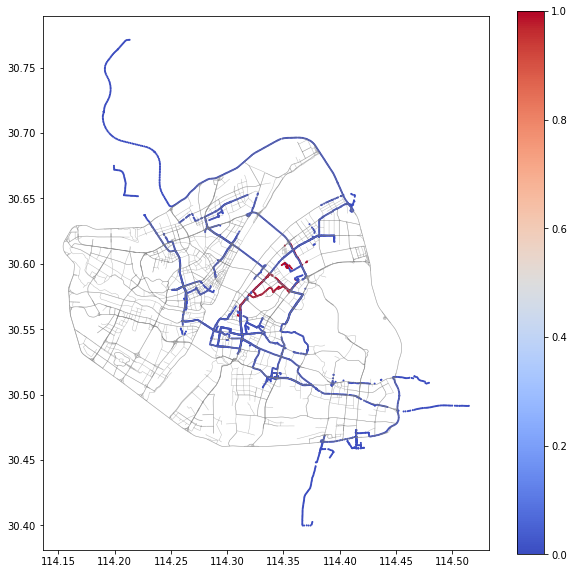

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def get_frequent_track(labels, track_dicts, tdf):  # 统计聚类中出现最频繁的轨迹类型，将其通过标记字段与其他类型轨迹区分开
    max_label = max(labels, key=labels.count)  # 统计频繁轨迹所属的类    
    frequent_TID = [track_dicts[i]['track_id'] for i in range(0, len(track_dicts)) if track_dicts[i]['cluster'] == max_label]  # 统计频繁轨迹ID（TID）
    tdf['frequency'] = 0
    new_df = tdf
    for ids in frequent_TID: new_df.loc[(new_df.TID == ids), 'frequency'] = 1  # 频繁轨迹的frequency字段值为1，非频繁轨迹的frequency字段值为0
    return new_df

frequent_tracks_df = get_frequent_track(cluster1.tolist(), track_coords_1110 , selected_tracks_by_car_id)  # 在实验轨迹数据中标记出聚类所得的频繁轨迹
'''使用geopandas可视化出租车轨迹的方法我们在上次实习中已经涉及，此处同样还需用到'''
frequent_gdf = gpd.GeoDataFrame(frequent_tracks_df, geometry=gpd.points_from_xy(frequent_tracks_df['经度'], frequent_tracks_df['纬度']))
track_ax = frequent_gdf.plot(column='frequency',cmap='coolwarm',legend=True,markersize=1,figsize=(10,10))  # 必要的绘图设置
wuhan_road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')  # 叠加武汉市路网
wuhan_road.plot(ax = track_ax, linewidth = 0.5, alpha = 0.5, color = 'grey')

# 3.轨迹异常检测

Detecting anomalous trajectories and behavior patterns using hierarchical clustering from taxi GPS data(Wang,Y.,Qin,K.,Chen,Y.,&Zhao,P.)论文提供了一种轨迹异常探测的流程，如下图所示  

计算轨迹距离/相似性矩阵
进行层次聚类
通过统计指标确定最佳聚类个数
根据统计指标识别异常轨迹

需要说明的是，

论文中使用的距离指标为改进的编辑距离，考虑到计算速度我们实习中还是使用前面习惯的dtw距离
论文中使用了多个统计指标对比来确定最佳聚类个数，实习指导中只用WB指标，请同学们自己分析另外两个指标，公式后面将给出

按空间范围  (114.32, 30.53)  到  (114.43, 30.62) 和时间范围  2018-11-10 07:00:00  到  2018-11-10 21:00:00 取轨迹
共  725816  行数据
其中有不同出租车共  2040  辆
时间覆盖范围从  2018-11-10 07:00:00  到  2018-11-10 21:00:00
空间覆盖范围从  114.32 , 30.53  到  114.43 , 30.62


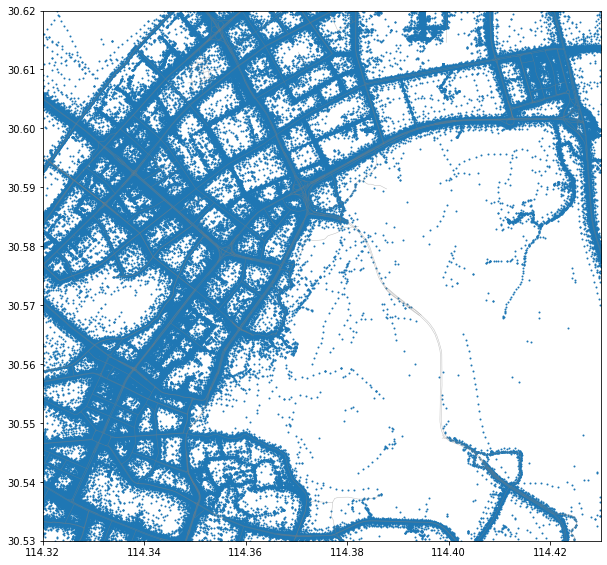

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


def look_into_df(df):
    print('共 ',len(df),' 行数据')
    print('其中有不同出租车共 ',len(df['出租车ID'].unique()),' 辆')
    print('时间覆盖范围从 ',min(df['定位时间']),' 到 ',max(df['定位时间']))
    print('空间覆盖范围从 ',min(df['经度']),',',min(df['纬度']),' 到 ',max(df['经度']),',',max(df['纬度']))

#时空范围过滤
def get_sub_df(df,posrange,timerange):
    print('按空间范围 ',posrange[0],' 到 ',posrange[1],'和时间范围 ',timerange[0],' 到 ',timerange[1],'取轨迹')
    sub_df=pd.DataFrame()
    sub_df=df[(df['经度']>=posrange[0][0]) & (df['纬度']>=posrange[0][1]) & (df['经度']<=posrange[1][0]) & (df['纬度']<=posrange[1][1])]
    sub_df=sub_df[(sub_df['定位时间']>=timerange[0]) & (sub_df['定位时间']<=timerange[1])]
    look_into_df(sub_df)
    sub_df=sub_df.reset_index(drop=True)
    return sub_df

def visualize(df):
    gdf= gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['经度'], df['纬度']),crs=4326)
    # 使matplotlib支持中文字体
    plt.rcParams['font.family']=['SimHei']
    ax=gdf.plot(markersize=1,figsize=(10,10))
    # 指定范围
    ax.set_ylim([min(df['纬度']),max(df['纬度'])])
    ax.set_xlim([min(df['经度']),max(df['经度'])])
    # 叠加武汉市路网
    road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
    road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

df=pd.read_csv('/content/gdrive/MyDrive/Wuhan_taxi_data/processed.csv')
sub_df=get_sub_df(df,[(114.32,30.53),(114.43,30.62)],['2018-11-10 07:00:00','2018-11-10 21:00:00'])#街道口周围
visualize(sub_df)#(114.32,30.53),(114.43,30.62)

## 3.2 计算轨迹距离矩阵

In [ ]:
import time,datetime
import math

def get_sub_trac(df):
    tracks=[]
    # 辅助记录
    idx1=0
    tid1=df.loc[idx1,'出租车ID']
    time1=datetime.datetime.strptime(df.loc[idx1,'定位时间'], "%Y-%m-%d %H:%M:%S")
    for index, row in df.iterrows():
        idx2=index
        tid2=row['出租车ID']
        time2=datetime.datetime.strptime(row['定位时间'], "%Y-%m-%d %H:%M:%S")
        
        #不同车或时间差太长
        if tid2!=tid1 or (time2-time1).seconds>120:
            sub_df=df[idx1:idx2]
            if idx2-idx1>=10:
                tracks.append(sub_df)
            idx1=idx2
            time1=time2
            tid1=tid2
        else:
            time1=time2
            
    #用于加入最后一条轨迹，因为可能最后一条轨迹并不完整，但为了不浪费这条轨迹，作此处理
    if idx2-idx1>=9:
        sub_df=df[idx1:idx2+1]
    tracks.append(sub_df)
    return tracks

def get_track_coords(tdf, tIDs):
    tracks = []  # 存放轨迹中各点的经纬度坐标序列
    new_id = 1
    for ids in tIDs:
        if ids % 1000 == 0:print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())) # 报时
        track_lons = tdf[tdf['TID'] == ids]['经度'].values.tolist()
        track_lats = tdf[tdf['TID'] == ids]['纬度'].values.tolist()
        tracks.append({'id':new_id, 'taxi': tdf[tdf['TID'] == ids]['出租车ID'].values.tolist()[0], 'track_id': ids,
                       'start':tdf[tdf['TID'] == ids]['定位时间'].values.tolist()[0], 'end':tdf[tdf['TID'] == ids]['定位时间'].values.tolist()[-1],'coords': [track_lons, track_lats]})  # 重新为选取的轨迹编号
        new_id += 1
    return tracks

tracks0=get_sub_trac(sub_df)#轨迹分段

In [ ]:
new_df=pd.DataFrame()
tid=1
for trac in tracks0:
    trac=trac.reset_index(drop=True)
    #选取从武汉站出发，到达武昌站的轨迹
    if abs(trac.loc[0,'经度']-114.43)<0.01 and abs(trac.loc[0,'纬度']-30.61)<0.01 and abs(trac.loc[len(trac)-1,'经度']-114.32)<0.01 and abs(trac.loc[len(trac)-1,'纬度']-30.53)<0.01:
        trac['TID']=tid
        tid+=1
        new_df=new_df.append(trac)

new_df=new_df.reset_index(drop=True)
tIDs = new_df['TID'].unique().tolist()
tracks=get_track_coords(new_df,tIDs)

#打印符合条件的轨迹条数
print(len(tracks))

6


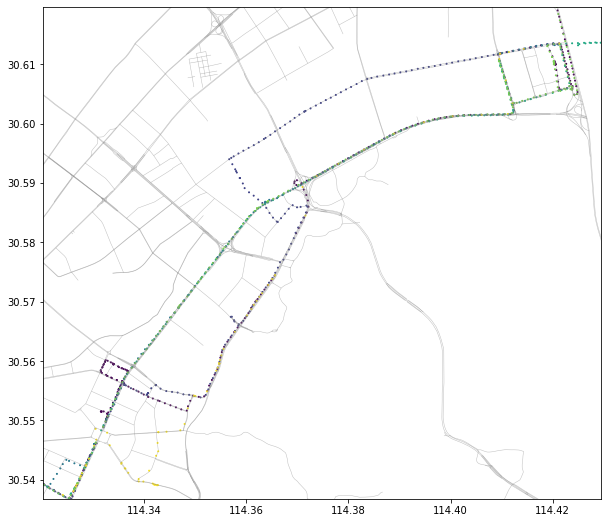

In [ ]:
#将符合条件的轨迹可视化
gdf= gpd.GeoDataFrame(
        new_df, geometry=gpd.points_from_xy(new_df['经度'], new_df['纬度']),crs=4326)
# 使matplotlib支持中文字体
plt.rcParams['font.family']=['SimHei']
ax=gdf.plot(markersize=1,figsize=(10,10),column='TID')
# 指定范围
ax.set_ylim([min(new_df['纬度']),max(new_df['纬度'])])
ax.set_xlim([min(new_df['经度']),max(new_df['经度'])])
# 叠加武汉市路网
road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax1 = road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')
ax1.get_figure().savefig('/content/gdrive/MyDrive/Wuhan_taxi_data/img/track.png', dpi=300, bbox='tight')

In [ ]:
import numpy as np
import math
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
def np_dtw_matrix(dataset):
    N = len(dataset)
    res = np.zeros((N,N),dtype='float32')
    for i in range(N):
        if i % 50 == 0: print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))  # 较多时间用于动态得求出两条一般的轨迹的间距
        for j in range(i+1, N):
            dis_lon, _ = fastdtw(dataset[i]['coords'][0], dataset[j]['coords'][0], dist=euclidean)
            dis_lat, _ = fastdtw(dataset[i]['coords'][1], dataset[j]['coords'][1], dist=euclidean)
            res[i,j] = math.sqrt(dis_lat**2 + dis_lon**2)
            res[j,i] = res[i,j]  # 通过求解矩阵的一半来加快部分运行的效率
    return res 

dtw_matr = np_dtw_matrix(tracks)
print(dtw_matr)

2022-10-11 07:51:51
[[0.         0.55603766 0.40836027 0.38192156 0.3572771  0.53570276]
 [0.55603766 0.         0.27023047 0.3619741  0.3849722  0.38978598]
 [0.40836027 0.27023047 0.         0.14866316 0.19811395 0.20754142]
 [0.38192156 0.3619741  0.14866316 0.         0.17594633 0.28794235]
 [0.3572771  0.3849722  0.19811395 0.17594633 0.         0.38126832]
 [0.53570276 0.38978598 0.20754142 0.28794235 0.38126832 0.        ]]


## 3.3 层次聚类和聚类个数的确定

一般来说对于聚类评判，其目标都是最大化类间距离、最小化类内距离，涉及到SSW和SSB两个基本指标。
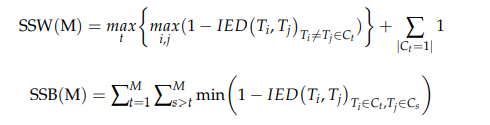

层次聚类：

假设有 n 个待聚类的样本，对于层次聚类算法，它的步骤是：
1. 初始化,将每个样本都视为一个聚类；
2. 计算各个聚类之间的相似度；
3. 寻找最近的两个聚类，将他们归为一类；
4. 重复2，3；直到所有样本归为一类。

In [ ]:
import scipy
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

def ssw_ssb(dtw_matr,cluster):
    m=list(set(cluster))
    ssw=99999999
    sswt=0
    ssb=0
    for i in m:
        idx1 = [c for c in range(len(cluster)) if cluster[c] == i]
        if len(idx1)==1:
            sswt+=1
        else:
            for p in idx1:
                for q in idx1:
                    if p!=q:
                        if dtw_matr[p,q]<ssw:#求最小值（类内差距最小）
                            ssw=dtw_matr[p,q]
        for j in m:
            idx2 = [c for c in range(len(cluster)) if cluster[c] == j]
            for p in idx1:
                for q in idx2:
                    if dtw_matr[p,q]>ssb:#求最大值（类间差距最大）
                        ssb=dtw_matr[p,q]
        return 1-ssw+sswt,1-ssb

统计指标有三种，均有指标值越小、聚类效果越好的含义

使用WB-index、CH-index和Xu-index等统计指标对比来确定最佳聚类个数。

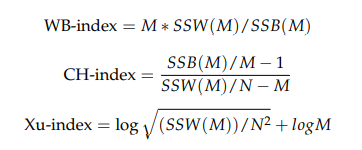

In [ ]:
# WB-index
def wbindex(ssw,ssb,m):
    m=float(m)
    return m*ssw/ssb

# CH-index
def chindex(ssw,ssb,m,n):
    m=float(m)
    return ((ssb/m)-1)/(ssw/n-m)

# Xu-index
from math import log,sqrt
def xuindex(ssw,ssb,m,n):
    m=float(m)
    return (log(sqrt(ssw/(n*n)))+log(m))

In [ ]:
wbs=[]
possible=range(2,len(tracks))#可能的聚类数
for i in possible:
    Z = linkage(dtw_matr,method='ward') #层次聚类
    cluster=fcluster(Z, t=i, criterion='maxclust') 
    print(cluster)
    ssw,ssb=ssw_ssb(dtw_matr,cluster.tolist())
    wb=wbindex(ssw,ssb,i)
    print(wb)
    wbs.append(wb)
print('WB-index最佳聚类数为：',possible[wbs.index(min(wbs))])

[2 1 1 1 1 1]
3.8351759533390295
[3 2 1 1 1 2]
4.316834033216074
[4 2 1 1 1 3]
5.7557787109547665
[4 2 1 1 1 3]
7.194723388693458
WB-index最佳聚类数为： 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


In [ ]:
chs=[]
possible=range(2,len(tracks))#可能的聚类数
for i in possible:
    Z =linkage(dtw_matr,method='ward') #层次聚类
    cluster=fcluster(Z, t=i, criterion='maxclust') 
    print(cluster)
    ssw,ssb=ssw_ssb(dtw_matr,cluster.tolist())
    ch=chindex(ssw,ssb,i,len(tracks))
    print(ch)
    chs.append(ch)
print('CH-index最佳聚类数为：',possible[chs.index(max(chs))])

[2 1 1 1 1 1]
0.418715044567433
[3 2 1 1 1 2]
0.28088023535458284
[4 2 1 1 1 3]
0.22085683190119348
[4 2 1 1 1 3]
0.18148456063180532
CH-index最佳聚类数为： 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


In [ ]:
xus=[]
possible=range(2,len(tracks))#可能的聚类数
for i in possible:
    Z=linkage(dtw_matr,method='ward') #层次聚类
    cluster=fcluster(Z, t=i, criterion='maxclust') 
    print(cluster)
    ssw,ssb=ssw_ssb(dtw_matr,cluster.tolist())
    xu=xuindex(ssw,ssb,i,len(tracks))
    print(xu)
    xus.append(xu)
print('Xu-index最佳聚类数为：',possible[xus.index(min(xus))])

[2 1 1 1 1 1]
-1.179085996557403
[3 2 1 1 1 2]
-0.7736208884492386
[4 2 1 1 1 3]
-0.4859388159974578
[4 2 1 1 1 3]
-0.2627952646832481
Xu-index最佳聚类数为： 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


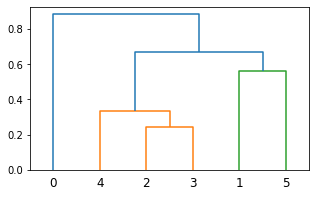

In [ ]:
# 层次聚类，选择沃德方差最小化算法，生成聚类结果的可视化聚类树
Z=linkage(dtw_matr,method='ward')
cluster=fcluster(Z, t=2, criterion='maxclust')
fig=plt.figure(figsize=(5, 3))
dn=dendrogram(Z)
plt.savefig('/content/gdrive/MyDrive/Wuhan_taxi_data/img/cengci.png', dpi=200, bbox='tight')
plt.show()

在论文中，作者指出聚类中轨迹数目为1的是异常轨迹，在这里依次统计每个元素出现的次数，找出异常轨迹的编号。

In [ ]:
new_df['cluster'] = 2
new_df.loc[new_df['TID']==1, 'cluster'] = 1
new_df

,出租车ID,定位时间,经度,纬度,方向,速度,空车/重车,geometry,TID,cluster
0,18807,2018-11-10 17:02:03,114.420942,30.619047,164,59,重车,POINT (114.42094 30.61905),1,1
1,18807,2018-11-10 17:02:10,114.421253,30.617995,164,65,重车,POINT (114.42125 30.61800),1,1
2,18807,2018-11-10 17:02:16,114.421505,30.617085,164,60,重车,POINT (114.42150 30.61708),1,1
3,18807,2018-11-10 17:02:23,114.421787,30.616110,164,55,重车,POINT (114.42179 30.61611),1,1
4,18807,2018-11-10 17:02:31,114.422073,30.615160,164,38,重车,POINT (114.42207 30.61516),1,1
...,...,...,...,...,...,...,...,...,...,...
1083,9769,2018-11-10 15:08:53,114.327582,30.540478,0,0,空车,POINT (114.32758 30.54048),6,2
1084,9769,2018-11-10 15:09:23,114.326889,30.539187,200,10,空车,POINT (114.32689 30.53919),6,2
1085,9769,2018-11-10 15:09:53,114.326747,30.538909,0,0,空车,POINT (114.32675 30.53891),6,2
1086,9769,2018-11-10 15:10:23,114.326231,30.538076,212,25,空车,POINT (114.32623 30.53808),6,2


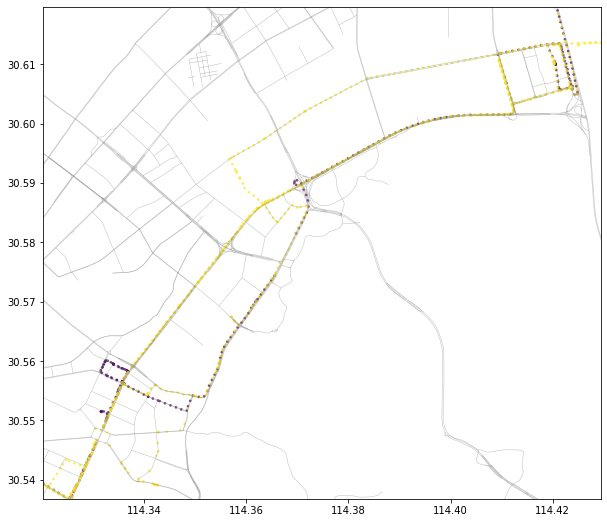

In [ ]:
#将符合条件的轨迹可视化
gdf= gpd.GeoDataFrame(
        new_df, geometry=gpd.points_from_xy(new_df['经度'], new_df['纬度']),crs=4326)
# 使matplotlib支持中文字体
plt.rcParams['font.family']=['SimHei']
ax=gdf.plot(markersize=3,figsize=(10,10),column='cluster', alpha=0.6)
# 指定范围
ax.set_ylim([min(new_df['纬度']),max(new_df['纬度'])])
ax.set_xlim([min(new_df['经度']),max(new_df['经度'])])
# 叠加武汉市路网
road = gpd.GeoDataFrame.from_file('/content/gdrive/MyDrive/Wuhan_taxi_data/data/road/WHroad.shp')
ax1 = road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')
ax1.get_figure().savefig('/content/gdrive/MyDrive/Wuhan_taxi_data/img/error_track.png', dpi=300, bbox='tight')

In [ ]:
for i in np.unique(cluster):
    if (np.sum(cluster==i)==1):
        print('异常轨迹',list(cluster).index(i))

异常轨迹 0


## 3.5 异常轨迹探测

轨迹时间和距离均值计算

In [ ]:
from datetime import datetime, date
from math import radians, cos, sin, asin, sqrt

def time_cal(index):
# 计算轨迹的时间，单位为分钟
    time=datetime.strptime( pd.DataFrame(tracks)['end'][index],"%Y-%m-%d %H:%M:%S")- datetime.strptime( pd.DataFrame(tracks)['start'][index],"%Y-%m-%d %H:%M:%S")
    time=time.seconds/60.0
    return time
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
# 计算两个位置点之间的弧长
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r 

def distance_cal(index):
    tot=0
    for i in range(len(tracks[index]['coords'][0])):

        lon1=tracks[index]['coords'][0][i]
        lon2=tracks[index]['coords'][0][i+1]
        lat1=tracks[index]['coords'][1][i]
        lat2=tracks[index]['coords'][1][i+1]
        tot+=haversine(lon1, lat1, lon2, lat2)
        if i==(len(tracks[index]['coords'][0])-2):
            break
    return tot

平均时间: 43.67499999999999
平均长度: 18.376721936255304


Text(0.5, 1.0, 'Distance')

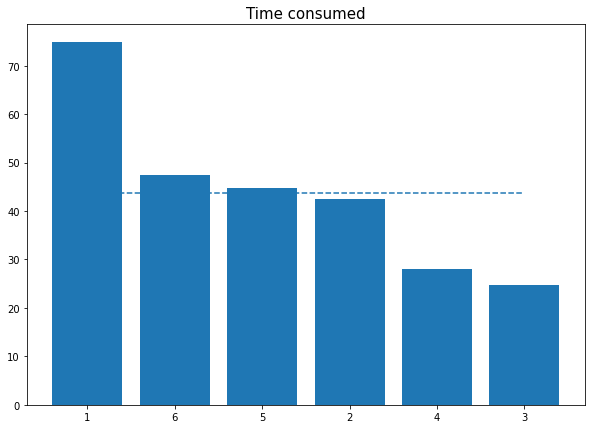

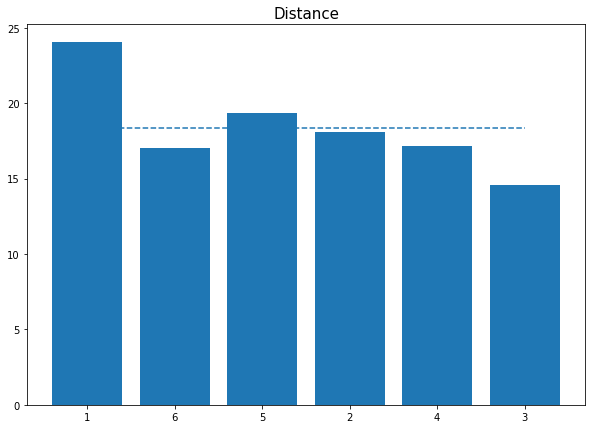

In [ ]:
times=0
distances=0
for index,item in enumerate(tracks):
    tracks[index]['time']=time_cal(index)
    times+=tracks[index]['time']
    tracks[index]['length']=distance_cal(index)
    distances+=tracks[index]['length']
avg_time=times/len(tracks)
avg_length=distances/len(tracks)

print('平均时间:',avg_time)
print('平均长度:',avg_length)

# 对轨迹的耗时以及距离进行排序
sorted_tracks=pd.DataFrame(sorted(tracks,key = lambda x: x.__getitem__('time'),reverse=True))
sorted_tracks2=pd.DataFrame(sorted(tracks,key = lambda x: x.__getitem__('length'),reverse=True))

# 对轨迹的耗时以及平均耗时做直方图可视化
x1=list(map(str,sorted_tracks['track_id']))
y1=sorted_tracks['time']
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(x1, [avg_time for _ in range(len(tracks)) ],'--',label='mean time consumed')
ax.bar(x=x1, height=y1)
ax.set_title("Time consumed", fontsize=15)

# 对轨迹的距离以及平均距离做直方图可视化
x2=list(map(str,sorted_tracks['track_id']))
y2=sorted_tracks['length']
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(x2, [avg_length for _ in range(len(tracks)) ],'--',label='mean distance')
ax.bar(x=x2, height=y2)
ax.set_title("Distance", fontsize=15)